In [860]:

import tensorflow as tf
from tensorflow import keras
import time
tf.get_logger().setLevel(40) # suppress deprecation messages
from tensorflow import keras
from keras.models import Model, load_model
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.neighbors import DistanceMetric
# from tslearn.datasets import UCR_UEA_datasets
# from tslearn.neighbors import NearestNeighbors, KNeighborsTimeSeries, KNeighborsTimeSeriesClassifier
from tslearn.neighbors import KNeighborsTimeSeries
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
# from counterfactual_utils import label_encoder, ucr_data_loader
# from XAI_thesis_project.Instance-Based_CFE_TSC.counterfactual_utils import label_encoder, ucr_data_loader
# from Native_Guide.Native_Guide_Methods.counterfactual_utils import label_encoder, ucr_data_loader
print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

TF version:  2.11.0
Eager execution enabled:  True


In [861]:
import config
from process_data import *

"""
Configuration
"""
dataset_name = "ECG200"
class_names = config.class_names
classifier_name = "CNN"
random_seed = 333
test_id = 555
save_cls = False
## SSSS
pos_indice = []
neg_indice = []

"""
1 - Process dataset and get processed data
"""
X_train, y_train, X_test, y_test = process_ucr_dataset(dataset_name)
y_train = Unify_class_names(y_train, dataset_name=dataset_name)
y_test = Unify_class_names(y_test, dataset_name=dataset_name)
positive_nums, negative_nums = get_dataset_info_group_by_class(y_train)
print("Positive nums: ", positive_nums, "Negative nums: ", negative_nums)
seq_length = X_train.iloc[0][0].shape[0]
print("Dataset: ", dataset_name)
print("Random Seed: ", random_seed)

for idx, label in enumerate(y_test):
    if label == '1':
        pos_indice.append(idx)
    else:
        neg_indice.append(idx)
print("Positive instance ids: ", pos_indice)
print("Negative instance ids: ", neg_indice)

Positive nums:  1755 Negative nums:  1846
Dataset:  FordA
Random Seed:  333
Positive instance ids:  [3, 5, 8, 9, 11, 13, 15, 20, 22, 24, 26, 27, 33, 34, 35, 37, 40, 42, 44, 47, 49, 52, 60, 61, 62, 63, 65, 67, 69, 72, 76, 78, 81, 82, 86, 87, 90, 91, 92, 96, 100, 102, 106, 108, 110, 114, 115, 118, 122, 124, 126, 129, 130, 131, 132, 133, 134, 142, 143, 144, 145, 146, 147, 149, 150, 151, 154, 155, 158, 159, 161, 162, 165, 166, 171, 172, 173, 174, 175, 177, 178, 180, 184, 185, 186, 187, 188, 191, 193, 194, 197, 199, 200, 201, 202, 203, 205, 206, 207, 209, 210, 211, 213, 222, 223, 224, 225, 226, 227, 228, 231, 233, 234, 236, 239, 240, 241, 245, 247, 249, 252, 253, 254, 256, 257, 259, 262, 263, 264, 265, 267, 270, 273, 279, 281, 282, 284, 286, 288, 289, 291, 293, 294, 296, 297, 298, 301, 302, 304, 307, 313, 315, 316, 317, 318, 319, 324, 326, 331, 332, 343, 344, 345, 348, 355, 356, 357, 359, 360, 363, 364, 366, 367, 370, 372, 376, 377, 378, 379, 382, 387, 388, 390, 393, 397, 399, 400, 402, 409

In [862]:
from sktime.classification.interval_based import DrCIF
from sktime.classification.feature_based import Catch22Classifier
from sklearn.ensemble import RandomForestClassifier
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.classification.deep_learning.cnn import CNNClassifier
assert classifier_name in ["KNN", "CNN", "DrCIF", "Catch22"]
clf = None
if classifier_name == "KNN":
    # (1) KNN-l2
    clf = KNeighborsTimeSeriesClassifier(distance="euclidean")
elif classifier_name == "CNN":
    # (2) CNN
    clf = CNNClassifier(random_state=random_seed)
elif classifier_name == "DrCIF":
    # (3) DrCIF
    clf = DrCIF(
        n_estimators=3, n_intervals=2, att_subsample_size=2, random_state=random_seed
    )
elif classifier_name == "Catch22":
    # (4) Catch22
    clf = Catch22Classifier(
        estimator=RandomForestClassifier(n_estimators=5),
        outlier_norm=True,
        random_state=random_seed
    ) 
 
print("(1) Training classifier " , classifier_name, " ......", clf)
print()
classifier_path = "Classifiers_Models/" + classifier_name + "/" + classifier_name + "_" + dataset_name + "_" + str(random_seed)
if save_cls:
    print("Fitting model ...", )
    clf.fit(X_train, y_train)
    clf.save(path=classifier_path)
    print("Model saved to ", classifier_path)
else:
    clf = clf.load_from_path(classifier_path + ".zip")
    print("Loading model at " + classifier_path)
y_pred = clf.predict(X_test)
print("Report: ")
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=class_names))
print()

(1) Training classifier  CNN  ...... CNNClassifier(random_state=333)

Loading model at Classifiers_Models/CNN/CNN_FordA_333
83/83 [==============================] - 0s 2ms/step
Report: 
              precision    recall  f1-score   support

           1       0.88      0.88      0.88       681
          -1       0.87      0.87      0.87       639

    accuracy                           0.87      1320
   macro avg       0.87      0.87      0.87      1320
weighted avg       0.87      0.87      0.87      1320




In [863]:
# Specify a to-be-explained instance from test set.

instance_id = test_id # Test set instance
to_be_explained_instance = X_test.iloc[instance_id][0].values.reshape(1, 1, seq_length)
to_be_explained_instance_label_y = y_test[instance_id]
to_be_explained_instance_predicted_y = clf.predict(to_be_explained_instance)[0]
from copy import copy
# original_instance = copy(to_be_explained_instance)
target_y = "1" if int(to_be_explained_instance_predicted_y) == -1 else "-1"
print("To-be-explained_instance_id: ", instance_id, ", Predicted: ", to_be_explained_instance_predicted_y, ", Truth: ", to_be_explained_instance_label_y, ", Target: ", target_y)
print()

1/1 [==============================] - 0s 17ms/step
To-be-explained_instance_id:  555 , Predicted:  1 , Truth:  1 , Target:  -1



In [864]:
# df to numpy
from sktime.datatypes._panel._convert import from_nested_to_2d_array
X_train_float = from_nested_to_2d_array(X_train).to_numpy()
X_test_float = from_nested_to_2d_array(X_test).to_numpy()
X_train = X_train_float
X_test = X_test_float
X_train.shape

(3601, 500)

In [865]:
#finding the nearest unlike neighbour. NB will need to account for regularization
# def native_guide_retrieval(query, predicted_label, distance, n_neighbors):
def native_guide_retrieval(query, predicted_label, distance, n_neighbors):
    
    df = pd.DataFrame(y_train, columns = ['label'])
    df.index.name = 'index'
    #df[df['label'] == 1].index.values, df[df['label'] != 1].index.values
    
    # ts_length = X_train.shape[1]
    ts_length = seq_length
    
    knn = KNeighborsTimeSeries(n_neighbors=n_neighbors, metric = distance)
    
    knn.fit(X_train[list(df[df['label'] != predicted_label].index.values)])
    
    dist,ind = knn.kneighbors(query.reshape(1,ts_length), return_distance=True)
    return dist[0], df[df['label'] != predicted_label].index[ind[0][:]]

In [866]:
# native_guide_retrieval(X_test[12], y_pred[12], 'dtw', 1)
# find instance closest to to-be-explained instance (different class)
target_dist, target_idx = native_guide_retrieval(to_be_explained_instance, to_be_explained_instance_label_y, 'dtw', 1)
target_dist, target_idx.tolist()[0]


e:\Software\AboutPrograming\Anaconda3\envs\sktime310\lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  warnings.warn(


(array([5.72684745]), 933)

In [867]:
# Check if it is a match
print("To-be-explained_instance_id: ", instance_id, ", Predicted: ", to_be_explained_instance_predicted_y, ", Truth: ", to_be_explained_instance_label_y, ", Target: ", target_y)
print("Predicted: ", y_pred[instance_id], ", Truth: ", y_test[instance_id], ", Target: ", y_train[target_idx.tolist()[0]])
# plt.plot(to_be_explained_instance.squeeze(), c='blue')

To-be-explained_instance_id:  555 , Predicted:  1 , Truth:  1 , Target:  -1
Predicted:  1 , Truth:  1 , Target:  -1


In [868]:
# (1) find instance closest to to-be-explained instance (same class), i.e., nearest neibour (NN)
knn = KNeighborsTimeSeries(n_neighbors=1, metric='dtw').fit(X_train)
dist_test, sim_idx = knn.kneighbors(X_test[instance_id].reshape(1,-1), return_distance=True)
dist_test, sim_idx

e:\Software\AboutPrograming\Anaconda3\envs\sktime310\lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  warnings.warn(


(array([[5.72684745]]), array([[933]], dtype=int64))

In [869]:
np.where(y_test != y_pred)

(array([   9,   10,   13,   16,   26,   33,   41,   54,   79,   84,   88,
          98,  112,  120,  121,  126,  132,  146,  148,  175,  183,  211,
         219,  223,  241,  275,  286,  297,  299,  312,  318,  319,  322,
         326,  345,  352,  356,  376,  382,  397,  425,  443,  444,  452,
         453,  459,  460,  482,  495,  501,  502,  512,  521,  530,  534,
         537,  546,  552,  554,  559,  579,  587,  600,  609,  613,  616,
         624,  640,  642,  644,  652,  654,  663,  670,  678,  686,  693,
         701,  706,  710,  738,  754,  755,  761,  773,  784,  796,  811,
         833,  840,  841,  861,  879,  881,  882,  900,  907,  912,  919,
         924,  936,  939,  941,  943,  957,  961,  962,  965,  971,  978,
         986,  988,  994,  995, 1006, 1007, 1013, 1018, 1027, 1034, 1043,
        1048, 1053, 1055, 1056, 1060, 1064, 1072, 1081, 1085, 1087, 1097,
        1115, 1117, 1121, 1123, 1138, 1144, 1148, 1152, 1160, 1164, 1173,
        1178, 1180, 1182, 1190, 1206, 

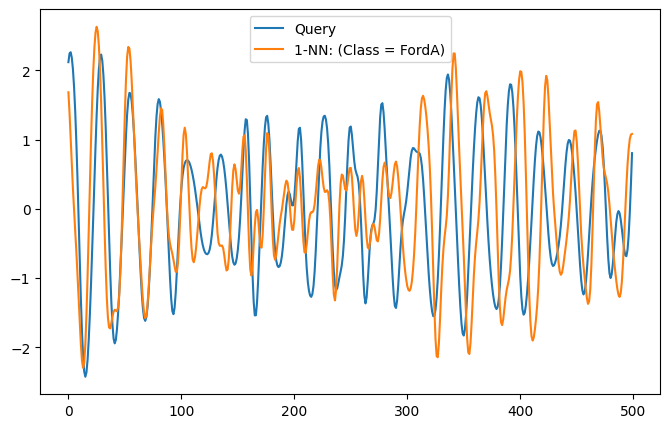

In [870]:
plt.figure(figsize=(8,5))
plt.plot(X_test[instance_id], label = 'Query')
plt.plot(X_train[sim_idx.tolist()[0][0]], label = '1-NN: (Class = ' + dataset_name + ")")
plt.legend()

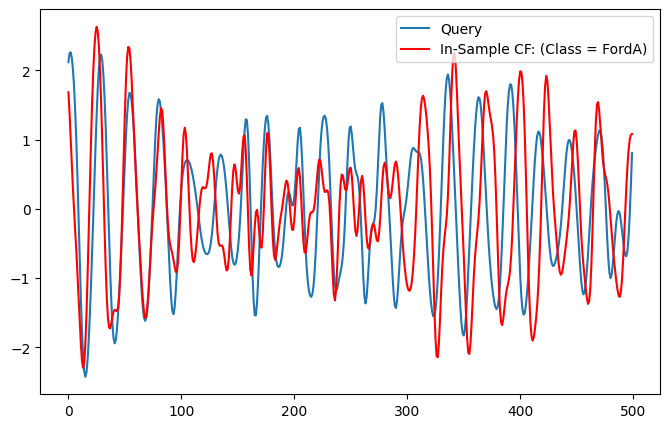

In [871]:
plt.figure(figsize=(8,5))
plt.plot(to_be_explained_instance.squeeze(), label = 'Query')
plt.plot(X_train[target_idx.tolist()[0]], c='red', label='In-Sample CF: (Class = ' + dataset_name + ")")
plt.legend()

In [872]:
from tslearn.barycenters import dtw_barycenter_averaging

In [873]:
# def target_(instance):
#     target = np.argsort((model.predict_proba(instance.reshape(1,-1))))[0][-2:-1][0] 
#     return target

In [874]:
str(target_y), to_be_explained_instance_predicted_y

('-1', '1')

In [875]:
to_be_explained_instance = to_be_explained_instance.squeeze()
to_be_explained_instance.shape

(500,)

### DTW-Case (Simple 1-NN DTW Classifier)

In [876]:
query = to_be_explained_instance.squeeze()
beta = 0
insample_cf = X_train[target_idx.tolist()[0]]
target = int(target_y)
pred_treshold = 0.5
generated_cf = dtw_barycenter_averaging([query, insample_cf], weights=np.array([(1-beta), beta]))
generated_cf = generated_cf.reshape(1, -1)
prob_target = clf.predict_proba(generated_cf)[0][target]
while prob_target < pred_treshold:
    beta += 0.01 
    generated_cf = generated_cf = dtw_barycenter_averaging([query, insample_cf], weights=np.array([(1-beta), beta]))
    prob_target = clf.predict_proba(generated_cf.reshape(1,-1))[0][target]
generated_cf = generated_cf.reshape(1, -1)
## SSSS
print("CF_Predicted", clf.predict(generated_cf)[0], ", Origin_Predicted", to_be_explained_instance_predicted_y)
print(generated_cf)

1/1 [==============================] - 0s 20ms/step
CF_Predicted 1 , Origin_Predicted 1
[[ 2.16613694  1.7661917   1.7661917   1.4192526   0.98164549  0.98164549
   0.4608979   0.4608979  -0.11698222 -0.71492424 -1.281375   -1.7661326
  -2.1285964  -2.1285964  -2.3791217  -2.1750202  -1.8910904  -1.5262132
  -1.0982433  -0.62500938 -0.12197034  0.39266756  0.89668952  1.3551494
   1.7426248   2.0266047   2.1907544   2.2300213   2.1402134   1.92974
   1.6084724   1.1872752   0.69126277  0.15192308 -0.39395053 -0.90341992
  -0.90341992 -1.3394821  -1.3394821  -1.6717148  -1.6717148  -1.90371177
  -1.7387743  -1.502947   -1.502947   -1.209071   -0.86993192 -0.49814414
  -0.10115183  0.50749049  1.0699336   1.3685947   1.576855    1.6753398
   1.6753398   1.6753398   1.6666964   1.46208135  1.1143699   0.81600683
   0.48358373  0.12703256 -0.24177053 -0.60475122 -0.94072439 -1.2300407
  -1.4474705  -1.5783326  -1.6180004  -1.5673341  -1.4290479  -1.2075761
  -0.91244749 -0.55215502 -0.1490

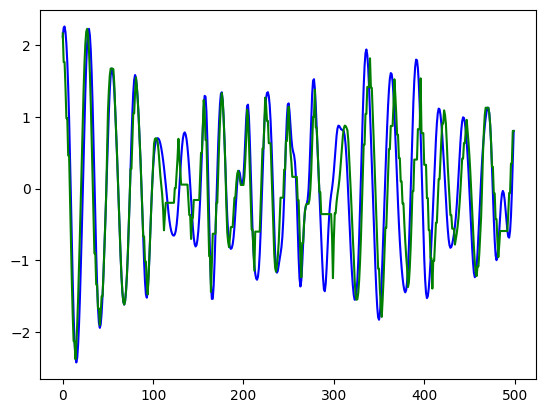

In [877]:
plt.plot(to_be_explained_instance, c='blue')
plt.plot(generated_cf.squeeze(), c='green', label='Generated CF')


In [878]:
# Experiment
if clf.predict(generated_cf)[0] != to_be_explained_instance_predicted_y:
    print("Matching")
    import experiment
    if_model = experiment.train_isolation_forest(X_train, random_seed)
    closeness_l1 = experiment.calculate_closeness(generated_cf, to_be_explained_instance, "l1")
    ## Closeness: L2
    closeness_l2 = experiment.calculate_closeness(generated_cf, to_be_explained_instance, "l2")
    ## Sparsity
    sparsity = experiment.calculate_sparsity(generated_cf, to_be_explained_instance)

    isolation_predict = experiment.predict_outlier_with_isolation_forest(if_model, generated_cf)
    print("Closeness_l1: ", closeness_l1, ", Closeness_l2: ", closeness_l2, ", Sparsity: ", sparsity, ", Out-of-distribution: ", isolation_predict)
else:
    print("Not Found")
## SSSS

from datetime import datetime
now = datetime.now()
print("Now: ", now)
print("Dataset: ", dataset_name)
print("Random Seed: ", random_seed)
print("To-be-explained_instance_id: ", instance_id, ", Predicted: ", to_be_explained_instance_predicted_y, ", Truth: ", to_be_explained_instance_label_y, ", Target: ", target_y)
print("(1) Training classifier " , classifier_name, " ......", clf)

1/1 [==============================] - 0s 19ms/step
Not Found
Now:  2023-08-01 00:40:43.464977
Dataset:  FordA
Random Seed:  333
To-be-explained_instance_id:  555 , Predicted:  1 , Truth:  1 , Target:  -1
(1) Training classifier  CNN  ...... CNNClassifier(random_state=333)


In [879]:
# fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 8), facecolor="1")
# plt.xlabel('Time')
    
# axes[0].plot(X_test[12], label = 'Query')
# axes[0].plot(X_train[24], label = 'NN')
# axes[0].legend(loc='upper right', fontsize=12) 
# axes[0].set_xlabel('Time', rotation=0, size=16, fontweight='bold')
# axes[0].set_ylabel('Value', rotation=90, size=16, fontweight='bold')   
    
# axes[1].plot(X_test[12], label = 'Query')
# axes[1].plot(X_train[4],alpha = 0.7, label = 'NUN-CF', color='red')
# axes[1].legend(loc='upper right', fontsize=12)
# axes[1].set_xlabel('Time', rotation=0, size=16, fontweight='bold')


# axes[2].plot(X_test[12], label = 'Query')
# axes[2].plot(generated_cf,alpha = 0.7, label = 'Generated CF', color='darkmagenta')
# axes[2].legend(loc='upper right', fontsize=12)
# axes[2].set_xlabel('Time', rotation=0, size=16, fontweight='bold')


# axes[0].text(-4,2.3,'A.', fontsize=22, fontweight='bold')
# axes[1].text(-4,2.3,'B.', fontsize=22, fontweight='bold')
# axes[2].text(-4,2.3,'C.', fontsize=22, fontweight='bold')

# #plt.savefig('./Images/DTW_DBA_EXAMPLE.pdf')